## Learning the PDF of a single table attribute using a Feedforward Neural Network. (Will also try linear regression in a separate notebook)

The input for the model is a range predicate and the output should be a prediction for the selectivity.

i.e. Given the range $a \leq x \leq b$, the model predicts the following:

$selectivity(a \leq x \leq b) = P(a \leq x \leq b)$

where $P(x)$ is the learned probability density function.

Intseda of directly learning P(x), we will learn a model that predicts $P(a \leq x \leq b)$, i.e. it predicts range selectivity.

In [1]:
# auto reload all modules
%load_ext autoreload
%autoreload 2

from simple_cost_model import *
from tpch_qgen_class_v2 import *

import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from tqdm import tqdm

In [2]:
# set up query generator
qg = TPCH_QGEN(DBNAME='tpch10_skew')

# Get the statistics for all tables in the tpch database
tables, pk_columns = get_tpch_schema()
table_names = list(tables.keys())
stats = {}
estimated_rows = {}
for table_name in table_names:
    stats[table_name], estimated_rows[table_name] = get_table_stats(table_name, dbname="tpch10")

table_attributes = {}
for table_name in table_names:
    table_attributes[table_name] = list(stats[table_name].keys())

# create a dictionary and specify whether each attribute in each table is numeric or char
data_type_dict = {}
for table_name in tables.keys():
    for column_name, column_type in tables[table_name]:
        if ("INT" in column_type) or ("DECIMAL" in column_type) or ("BIT" in column_type):
            data_type_dict[column_name] = "numeric"
        else:
            data_type_dict[column_name] = "char"   

In [3]:
# load actual stats from pickle file
with open('tpch10_skew_stats.pkl', 'rb') as f:
    actual_stats = pickle.load(f)

#### Implement a function for computing the exact selectitiy of any range predicate using the actual statistics

In [4]:
# function for computing selectivity of one-sided range predicates using actual stats
def exact_selectivity_range(actual_table_stats, column_name, boundary_left, boundary_right):
    # make sure attribute data type is numeric
    if data_type_dict[column_name] != "numeric":
        raise ValueError("Attribute data type must be numeric")
    
    stats = actual_table_stats[column_name]
    total_rows = stats['total_count']
    #num_distinct = stats['distinct_count']
    min_value = stats['min']
    max_value = stats['max']
    histogram = stats['histogram']

    # check if histogram is available
    if histogram:
        # find all values that fall within the range
        selectivity = 0
        for value, count in histogram.items():
            if boundary_left <= value <= boundary_right:
                selectivity += count
     
        selectivity = selectivity / total_rows
    else:
        # if histogram is not available, use min and max values, assume uniform distribution
        selectivity = (min(max(boundary_left, min_value), max_value) - boundary_left) / (boundary_right - boundary_left)

    return selectivity

#### Pick an attribute from one of the tables for testing purposes.

In [5]:
table_name = "customer"
column_name = "c_nationkey"
actual_table_stats = actual_stats[table_name]
print(f"actual_stats for attribute {column_name}: {actual_table_stats[column_name]}")

# test out the function
boundary_left = 10
boundary_right = 20
exact_selectivity = exact_selectivity_range(actual_table_stats, column_name, boundary_left, boundary_right)

print(f"exact selectivity for range [{boundary_left}, {boundary_right}]: {exact_selectivity}")

actual_stats for attribute c_nationkey: {'min': 0, 'max': 24, 'total_count': 1500000, 'distinct_count': 25, 'histogram': {0: 47704, 1: 86742, 2: 53076, 3: 84877, 4: 70086, 5: 53448, 6: 44748, 7: 44405, 8: 61934, 9: 50617, 10: 57095, 11: 42172, 12: 51829, 13: 103247, 14: 36509, 15: 153124, 16: 46098, 17: 58485, 18: 61718, 19: 44427, 20: 56483, 21: 44522, 22: 51881, 23: 58816, 24: 35957}}
exact selectivity for range [10, 20]: 0.4741246666666667


#### Now lets train a feedforward neural network to predict the selectivity.

In [6]:
# Define a simple neural network model for predicitng range selectivity
class SelectivityModel(nn.Module):
    def __init__(self, hidden_size=64):
        super(SelectivityModel, self).__init__()
        self.fc1 = nn.Linear(2, hidden_size)  # Input is [a, b]
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size//2)
        self.fc4 = nn.Linear(hidden_size//2, 1)  # Output is selectivity

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))  # Output as probability
        return x


In [7]:
def generate_range_predicate_samples(actual_stats, table_name, column_name, num_samples=100, fraction_eq=0.1):
    data = []
    stats = actual_stats[table_name][column_name]
    min_value = stats['min']
    max_value = stats['max']
    
    epsilon = 1e-6 * (max_value - min_value)

    # make sure that column stats has histogram, otherwise we cannot generate equality predicate samples
    if not actual_table_stats[column_name]['histogram']:
        fraction_eq = 0
    num_eq_samples = int(num_samples * fraction_eq)
    num_range_samples = num_samples - num_eq_samples
    
    # generate range predicate samples
    for i in range(num_range_samples):
        # generate a random start of the range
        a = np.random.uniform(min_value, 0.9*max_value)
        # generate a random end of the range, larger than a
        b = np.random.uniform(a, max_value)
        selectivity = exact_selectivity_range(actual_table_stats, column_name, a, b)
        data.append(([a, b], selectivity))

    # generate equality predicate samples
    for i in range(num_eq_samples):
        # draw a value from the histogram uniformly at random
        histogram = actual_table_stats[column_name]['histogram']
        values = list(histogram.keys())
        a = np.random.choice(values) 
        b = a + epsilon
        a = a - epsilon   
        selectivity = exact_selectivity_range(actual_table_stats, column_name, a, b)
        data.append(([a, b], selectivity))     

    # shuffle the data
    np.random.shuffle(data)

    return data

In [84]:
def train_NN(model, criterion, optimizer, data_loader, X_test, y_test, num_epochs, val_every=100):
    # training loop
    with tqdm(total=num_epochs, desc='Training Progress') as pbar:
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for inputs, targets in data_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            # compute MAE on the training set
            mae_train = torch.mean(torch.abs(outputs - targets))

            # Update the progress bar and print loss every 100 epochs
            if (epoch + 1) % 100 == 0:
                pbar.set_postfix({'Loss': f'{total_loss:.4f}', 'MAE': f'{mae_train.item():.4f}'})
            pbar.update(1)

            if (epoch + 1) % val_every == 0:
                model.eval()
                with torch.no_grad():
                    val_outputs = model(X_test)
                    val_loss = criterion(val_outputs, y_test)
                    # also compute the mean absolute error
                    mae_val = torch.mean(torch.abs(val_outputs - y_test))
                    # update pbar with validation loss and MAE
                    pbar.set_postfix({'Loss': f'{total_loss:.4f}', 'MAE':f'{mae_train.item():.4f}', 'Val Loss': f'{val_loss.item():.4f}', 'Val MAE': f'{mae_val.item():.4f}'})



In [85]:
table_name = "customer"
column_name = "c_nationkey"
actual_attribute_stats = actual_stats[table_name][column_name]
min_value = actual_attribute_stats['min']
max_value = actual_attribute_stats['max']

# generate a bunch of random range predicates and their selectivities
num_samples = 100
data = generate_range_predicate_samples(actual_stats, table_name, column_name, num_samples=num_samples, fraction_eq=0.2)

# split into training and testing data
train_size = int(0.8 * num_samples)
train_data = data[:train_size]
test_data = data[train_size:]

X_train = torch.tensor([d[0] for d in train_data], dtype=torch.float32)
y_train = torch.tensor([d[1] for d in train_data], dtype=torch.float32).view(-1, 1)

X_test = torch.tensor([d[0] for d in test_data], dtype=torch.float32)
y_test = torch.tensor([d[1] for d in test_data], dtype=torch.float32).view(-1, 1)


In [86]:
# hyperparameters
num_epochs = 1000
hidden_size = 32
batch_size = 32
l2_lambda = 0.001 # l2 regularization parameter

# Initialize the model, loss function, and optimizer
model = SelectivityModel(hidden_size=hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=l2_lambda)


# Create a dataset and data loader
dataset = TensorDataset(X_train, y_train)
train_data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  

In [87]:
# train the model
train_NN(model, criterion, optimizer, train_data_loader, X_test, y_test, num_epochs, val_every=10)

Training Progress: 100%|██████████| 1000/1000 [00:01<00:00, 507.65it/s, Loss=0.0031, MAE=0.0243, Val Loss=0.0025, Val MAE=0.0403]


In [88]:
# now evaluate the model on the test data
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f"Test loss: {test_loss.item()}")


# show side by side comparison of actual selectivity and predicted selectivity for all test data, along with the range
y_pred_array = y_pred.numpy().flatten()
y_test_array = y_test.numpy().flatten()
X_test_array = X_test.numpy()

for i in range(len(y_test)):
    a, b = X_test_array[i]
    print(f"Range: [{a:.4f}, {b:.4f}], Actual Selectivity: {y_test_array[i]:.4f}, Predicted Selectivity: {y_pred_array[i]:.4f}")



Test loss: 0.002503875643014908
Range: [9.1023, 21.5426], Actual Selectivity: 0.5038, Predicted Selectivity: 0.5482
Range: [10.3351, 13.9641], Actual Selectivity: 0.1315, Predicted Selectivity: 0.1650
Range: [19.9939, 23.0051], Actual Selectivity: 0.1411, Predicted Selectivity: 0.1183
Range: [8.8859, 16.2834], Actual Selectivity: 0.3605, Predicted Selectivity: 0.3481
Range: [10.0000, 10.0000], Actual Selectivity: 0.0381, Predicted Selectivity: 0.0533
Range: [4.1559, 21.9569], Actual Selectivity: 0.6739, Predicted Selectivity: 0.7534
Range: [6.6836, 20.8266], Actual Selectivity: 0.5788, Predicted Selectivity: 0.6102
Range: [0.7961, 14.8834], Actual Selectivity: 0.5605, Predicted Selectivity: 0.6312
Range: [12.0000, 12.0000], Actual Selectivity: 0.0346, Predicted Selectivity: 0.0515
Range: [4.7215, 16.2654], Actual Selectivity: 0.4968, Predicted Selectivity: 0.5041
Range: [19.3261, 23.9775], Actual Selectivity: 0.1411, Predicted Selectivity: 0.1927
Range: [4.5185, 21.8065], Actual Select

#### Comparison with Online Linear Regression

In [13]:
class SelectivityModelLR:

    def __init__(self, table_name, attribute_name, lambda_reg=0.1, epsilon=1e-8):
        self.table_name = table_name
        self.attribute_name = attribute_name
       
        # set feature dimensions
        self.features_per_attribute = 2
        self.feature_dims = self.features_per_attribute  
            
        self.V = lambda_reg * np.eye(self.feature_dims)
        self.b = np.zeros(self.feature_dims)
        self.theta = np.zeros(self.feature_dims)
        self.lambda_reg = lambda_reg
        self.epsilon = epsilon
        self.loss_history = []

    def update(self, input, target, verbose=False):
        x = np.array(input)
        #print(f"predicate: {predicate}, x: {x}")
        self.V += np.outer(x, x)
        self.b += target * x
        # add small epsilon to diagonal of V for conditioning
        #self.theta = np.linalg.solve(self.V + self.epsilon*np.eye(self.feature_dims), self.b)
        self.theta = np.linalg.solve(self.V, self.b)
        loss, y_pred = self.compute_loss(input, target)
        if verbose:
            print(f"Actual selectivity: {target}, predicted selectivity: {y_pred:.3f}, loss incurred: {loss}")

    
    def predict(self, input):
        x = np.array(input)
        # need to constrain the predicted selectivity to be between 0 and 1
        y_pred = np.dot(self.theta, x)
        y_pred = min(max(0, y_pred), 1)
        return y_pred


    def compute_loss(self, input, target):
        y_pred = self.predict(input)
        mse = (target - y_pred)**2
        reg = self.lambda_reg * np.dot(self.theta, self.theta)
        loss = mse + reg
        self.loss_history.append(loss)
        return loss, y_pred    
        


In [14]:
# create a simple linear regression model for the same attribute
table_name = "customer"
column_name = "c_nationkey"
actual_attribute_stats = actual_stats[table_name][column_name]
min_value = actual_attribute_stats['min']
max_value = actual_attribute_stats['max']

# generate training data
data = generate_range_predicate_samples(actual_stats, table_name, column_name, num_samples=100, fraction_eq=0.2)

# split into training and testing data
train_size = int(0.8 * num_samples)
train_data = data[:train_size]
test_data = data[train_size:]


In [15]:
def train_lr(model, train_data, val_data, val_every=10, verbose=False):
    #with tqdm(total=num_epochs, desc='Training Progress') as pbar:
        total_train_loss = 0
        mae_train = 0
        with tqdm(total=len(train_data), desc='Training Progress') as pbar:
            for i, (input, target) in enumerate(train_data):
                loss, y_pred = model.compute_loss(input, target)
                total_train_loss += loss
                mae_train += abs(target - y_pred)
                model.update(input, target)
                pbar.update(1)

                if (i + 1) % val_every == 0:
                    total_val_loss = 0
                    mae_val = 0
                    for input, target in val_data:
                        loss, y_pred = model.compute_loss(input, target)
                        total_val_loss += loss
                        mae_val += abs(target - y_pred)

                    total_val_loss /= len(val_data)
                    mae_val /= len(val_data)
                    
                pbar.set_postfix({'Train loss': f'{total_train_loss/(i+1):.4f}', 'Train MAE': f'{mae_train/(i+1):.4f}', 'Val loss': f'{total_val_loss:.4f}', 'Val MAE': f'{mae_val:.4f}'})

                if verbose: print(f"Train loss: {total_train_loss/(i+1):.4f}, Train MAE: {mae_train/(i+1):.4f}, Val loss: {total_val_loss:.4f}, Val MAE: {mae_val:.4f}")



In [16]:
# instantiate the LR model
lr_model = SelectivityModelLR(table_name, column_name, lambda_reg=0.01)

In [17]:
# train the model
train_lr(lr_model, train_data, test_data, val_every=1)

Training Progress: 100%|██████████| 80/80 [00:00<00:00, 1461.86it/s, Train loss=0.0013, Train MAE=0.0285, Val loss=0.0014, Val MAE=0.0296]


In [18]:
# show side by side comparison of actual selectivity and LR model predicted selectivity for all test data, along with the range
for input, target in test_data:
    a, b = input
    y_pred = lr_model.predict(input)
    print(f"Range: [{a:.4f}, {b:.4f}], Actual Selectivity: {target:.4f}, Predicted Selectivity: {y_pred:.4f}")


Range: [2.8650, 4.2191], Actual Selectivity: 0.1033, Predicted Selectivity: 0.0550
Range: [7.0000, 7.0000], Actual Selectivity: 0.0296, Predicted Selectivity: 0.0000
Range: [15.0112, 18.2667], Actual Selectivity: 0.1109, Predicted Selectivity: 0.1310
Range: [20.5279, 20.8555], Actual Selectivity: 0.0000, Predicted Selectivity: 0.0100
Range: [4.0000, 4.0000], Actual Selectivity: 0.0467, Predicted Selectivity: 0.0000
Range: [18.9405, 19.7190], Actual Selectivity: 0.0296, Predicted Selectivity: 0.0288
Range: [1.4614, 5.0490], Actual Selectivity: 0.1743, Predicted Selectivity: 0.1468
Range: [20.8057, 23.7549], Actual Selectivity: 0.1035, Predicted Selectivity: 0.1174
Range: [19.2745, 21.0633], Actual Selectivity: 0.0673, Predicted Selectivity: 0.0701
Range: [10.3486, 13.5541], Actual Selectivity: 0.1315, Predicted Selectivity: 0.1297
Range: [0.5859, 4.2437], Actual Selectivity: 0.1965, Predicted Selectivity: 0.1498
Range: [7.0000, 7.0000], Actual Selectivity: 0.0296, Predicted Selectivity:

### Training on artifically generated data distributions

In [116]:
# function for computing selectivity of one-sided range predicates using actual stats
def exact_selectivity_range_dist(boundary_left, boundary_right, total_rows, min_value, max_value, histogram=None):
    
    # find all values that fall within the range
    selectivity = 0
    for value, count in histogram.items():
        if boundary_left <= value <= boundary_right:
            selectivity += count
    
    selectivity = selectivity / total_rows

    return selectivity

In [80]:
def generate_range_predicate_samples_dist(total_rows, min_value, max_value, histogram, num_samples=100, fraction_eq=0.1):
    data = []
    epsilon = 1e-6 * (max_value - min_value)
    num_eq_samples = int(num_samples * fraction_eq)
    num_range_samples = num_samples - num_eq_samples
    
    # generate range predicate samples
    for i in range(num_range_samples):
        # generate a random start of the range
        a = np.random.uniform(min_value, 0.9*max_value)
        # generate a random end of the range, larger than a
        b = np.random.uniform(a, max_value)
        selectivity = exact_selectivity_range_dist(a, b, total_rows, min_value, max_value, histogram)
        data.append(([a, b], selectivity))

    # generate equality predicate samples
    for i in range(num_eq_samples):
        # draw a value from the histogram uniformly at random
        histogram = actual_table_stats[column_name]['histogram']
        values = list(histogram.keys())
        a = np.random.choice(values) 
        b = a + epsilon
        a = a - epsilon   
        selectivity = exact_selectivity_range_dist(a, b, total_rows, min_value, max_value, histogram)
        data.append(([a, b], selectivity))     

    # shuffle the data
    np.random.shuffle(data)

    return data

#### Learning a Uniform Distribution

In [89]:
# uniform distribution
min_value = 0
max_value = 99
num_distinct_values = 100
total_rows = 10000000

# use distribution function to generate values and counts for histogram
values = np.arange(min_value, max_value+1, (max_value+1-min_value)//num_distinct_values)
counts = (total_rows // num_distinct_values) * np.ones(num_distinct_values)

histogram = dict(zip(values, counts))

In [90]:
# generate some data
num_samples=150
data = generate_range_predicate_samples_dist(total_rows, min_value, max_value, histogram, num_samples=num_samples, fraction_eq=0.2)

# split into training and testing data
train_size = int(0.6 * num_samples)
train_data = data[:train_size]
test_data = data[train_size:]

print(f"Number of training samples: {len(train_data)}, Number of testing samples: {len(test_data)}")

X_train = torch.tensor([d[0] for d in train_data], dtype=torch.float32)
y_train = torch.tensor([d[1] for d in train_data], dtype=torch.float32).view(-1, 1)
X_test = torch.tensor([d[0] for d in test_data], dtype=torch.float32)
y_test = torch.tensor([d[1] for d in test_data], dtype=torch.float32).view(-1, 1)

Number of training samples: 90, Number of testing samples: 60


In [91]:
# instantiate NN and LR models
num_epochs = 1000
hidden_size = 32
batch_size = 32
l2_lambda = 0.001 # l2 regularization parameter

# instantiate the NN model, loss function, and optimizer
model = SelectivityModel(hidden_size=hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=l2_lambda)

# Create a dataset and data loader
dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  

# instantiate the LR model
lr_model = SelectivityModelLR(table_name, column_name, lambda_reg=0.01)

In [92]:
# train the models
print(f"Training NN model...")
train_NN(model, criterion, optimizer, data_loader, X_test, y_test, num_epochs, val_every=10)
print(f"Training LR model...")
train_lr(lr_model, train_data, test_data, val_every=1)

Training NN model...


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 1000/1000 [00:02<00:00, 477.58it/s, Loss=0.0013, MAE=0.0162, Val Loss=0.0004, Val MAE=0.0169]


Training LR model...


Training Progress: 100%|██████████| 90/90 [00:00<00:00, 1253.47it/s, Train loss=0.0004, Train MAE=0.0071, Val loss=0.0000, Val MAE=0.0040]


In [94]:
# evaluate both models on the test data
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f"NN Test loss: {test_loss.item()}")

# show side by side comparison of actual selectivity and predicted selectivity for all test data, along with the range
y_pred_array = y_pred.numpy().flatten()
y_test_array = y_test.numpy().flatten()
X_test_array = X_test.numpy()

for i in range(len(y_test)):
    a, b = X_test_array[i]
    lr_pred = lr_model.predict(X_test_array[i])
    print(f"Range: [{a:.4f}, {b:.4f}], Actual Selectivity: {y_test_array[i]:.4f}, NN Predicted Selectivity: {y_pred_array[i]:.4f}, LR Predicted Selectivity: {lr_pred:.4f}")    

NN Test loss: 0.00041398173198103905
Range: [0.9999, 1.0001], Actual Selectivity: 0.0087, NN Predicted Selectivity: 0.0471, LR Predicted Selectivity: 0.0000
Range: [77.5544, 93.3910], Actual Selectivity: 0.1600, NN Predicted Selectivity: 0.1579, LR Predicted Selectivity: 0.1583
Range: [3.6556, 58.5532], Actual Selectivity: 0.5500, NN Predicted Selectivity: 0.5680, LR Predicted Selectivity: 0.5487
Range: [4.6190, 76.1635], Actual Selectivity: 0.7200, NN Predicted Selectivity: 0.7389, LR Predicted Selectivity: 0.7150
Range: [55.5863, 90.6247], Actual Selectivity: 0.3500, NN Predicted Selectivity: 0.3613, LR Predicted Selectivity: 0.3502
Range: [11.9999, 12.0001], Actual Selectivity: 0.0052, NN Predicted Selectivity: 0.0413, LR Predicted Selectivity: 0.0000
Range: [9.9999, 10.0001], Actual Selectivity: 0.0057, NN Predicted Selectivity: 0.0421, LR Predicted Selectivity: 0.0000
Range: [17.5276, 34.9693], Actual Selectivity: 0.1700, NN Predicted Selectivity: 0.1828, LR Predicted Selectivity:

#### Learning a Gaussian Distribution

In [95]:
# truncated normal distribution
def normal_distribution(total_rows, min_value, max_value, x):
    # set mean and std deviation
    mean = (min_value + max_value) / 2
    std = (max_value - min_value) / 6

    # compute value of gaussian pdf at x
    pdf = np.exp(-0.5 * ((x - mean) / std)**2) / (std * np.sqrt(2 * np.pi)) 
    # convert to count
    count = pdf * total_rows
    return count

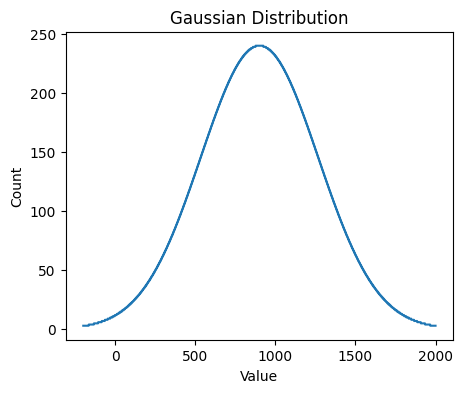

In [96]:
# gaussian distribution
min_value = -200
max_value = 2000
total_rows = 1000000
num_distinct_values = total_rows // 100

# use distribution function to generate values and counts for histogram
values = np.linspace(min_value, max_value, num_distinct_values)
counts = np.array([normal_distribution(total_rows, min_value, max_value, x) for x in values])

# normaize the counts so that they are integers and sum to total_rows
counts = counts / np.sum(counts) * total_rows
counts = np.round(counts)

histogram = dict(zip(values, counts))

# plot the histogram
plt.figure(figsize=(5, 4))
plt.plot(values, counts)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Gaussian Distribution")
plt.show()


In [107]:
# generate some data
num_samples=150
data = generate_range_predicate_samples_dist(total_rows, min_value, max_value, histogram, num_samples=num_samples, fraction_eq=0.2)

# split into training and testing data
train_size = int(0.6 * num_samples)
train_data = data[:train_size]
test_data = data[train_size:]

print(f"Number of training samples: {len(train_data)}, Number of testing samples: {len(test_data)}")

X_train = torch.tensor([d[0] for d in train_data], dtype=torch.float32)
y_train = torch.tensor([d[1] for d in train_data], dtype=torch.float32).view(-1, 1)
X_test = torch.tensor([d[0] for d in test_data], dtype=torch.float32)
y_test = torch.tensor([d[1] for d in test_data], dtype=torch.float32).view(-1, 1)

# normalize the input data for NN
X_train_normalized = X_train # (X_train - min_value) / (max_value - min_value)
X_test_normalized = X_test # (X_test - min_value) / (max_value - min_value)

Number of training samples: 90, Number of testing samples: 60


In [114]:
# instantiate NN and LR models
num_epochs = 5000
hidden_size = 32
batch_size = 32
l2_lambda = 0.001 # l2 regularization parameter

# instantiate the NN model, loss function, and optimizer
model = SelectivityModel(hidden_size=hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=l2_lambda)

# Create a dataset and data loader
dataset = TensorDataset(X_train_normalized, y_train)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  

# instantiate the LR model
lr_model = SelectivityModelLR(table_name, column_name, lambda_reg=0.01)

In [115]:
# train the models
print(f"Training NN model...")
train_NN(model, criterion, optimizer, data_loader, X_test_normalized, y_test, num_epochs, val_every=10)
print(f"Training LR model...")
train_lr(lr_model, train_data, test_data, val_every=1)

# evaluate both models on the test data
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f"NN Test loss: {test_loss.item()}")

# show side by side comparison of actual selectivity and predicted selectivity for all test data, along with the range
y_pred_array = y_pred.numpy().flatten()
y_test_array = y_test.numpy().flatten()
X_test_array = X_test.numpy()

for i in range(len(y_test)):
    a, b = X_test_array[i]
    lr_pred = lr_model.predict(X_test_array[i])
    print(f"Range: [{a:.4f}, {b:.4f}], Actual Selectivity: {y_test_array[i]:.4f}, NN Predicted Selectivity: {y_pred_array[i]:.4f}, LR Predicted Selectivity: {lr_pred:.4f}")    

Training NN model...


Training Progress: 100%|██████████| 5000/5000 [00:09<00:00, 504.96it/s, Loss=0.0207, MAE=0.0519, Val Loss=0.0092, Val MAE=0.0706]


Training LR model...


Training Progress: 100%|██████████| 90/90 [00:00<00:00, 1315.36it/s, Train loss=0.0132, Train MAE=0.0882, Val loss=0.0118, Val MAE=0.0861]

NN Test loss: 0.009218425489962101
Range: [490.3493, 1045.8795], Actual Selectivity: 0.5241, NN Predicted Selectivity: 0.3272, LR Predicted Selectivity: 0.3226
Range: [742.7738, 1944.2501], Actual Selectivity: 0.6657, NN Predicted Selectivity: 0.7899, LR Predicted Selectivity: 0.7115
Range: [922.7987, 964.7094], Actual Selectivity: 0.0453, NN Predicted Selectivity: 0.0721, LR Predicted Selectivity: 0.0000
Range: [845.1585, 1912.3763], Actual Selectivity: 0.5580, NN Predicted Selectivity: 0.6738, LR Predicted Selectivity: 0.6240
Range: [128.3185, 609.1077], Actual Selectivity: 0.1967, NN Predicted Selectivity: 0.3836, LR Predicted Selectivity: 0.2920
Range: [9.9978, 10.0022], Actual Selectivity: 0.0571, NN Predicted Selectivity: 0.0721, LR Predicted Selectivity: 0.0000
Range: [12.9978, 13.0022], Actual Selectivity: 0.1032, NN Predicted Selectivity: 0.0721, LR Predicted Selectivity: 0.0000
Range: [12.9978, 13.0022], Actual Selectivity: 0.1032, NN Predicted Selectivity: 0.0721, LR Predict

#### Learning Zipfian distribution

In [141]:
# skewed distribution - zipfian
def zipfian_distribution(total_rows, min_value, max_value, x, skew=2):
    a = min_value
    b = max_value
    k = skew
    count = min(total_rows, total_rows / (0.1*(x-min_value))**k)
    return count



/tmp/ipykernel_286261/2579596726.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  count = min(total_rows, total_rows / (0.1*(x-min_value))**k)


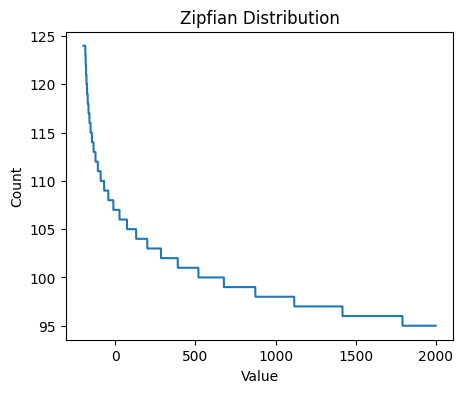

In [146]:
min_value = -200
max_value = 2000
total_rows = 10000000
num_distinct_values = total_rows // 100

# use distribution function to generate values and counts for histogram
values = np.linspace(min_value, max_value, num_distinct_values)
counts = np.array([zipfian_distribution(total_rows, min_value, max_value, x, skew=0.05) for x in values])

# normaize the counts so that they are integers and sum to total_rows
counts = total_rows * counts / np.sum(counts) 
counts = np.round(counts)

histogram = dict(zip(values, counts))

# plot the histogram
plt.figure(figsize=(5, 4))
plt.plot(values, counts)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Zipfian Distribution")
plt.show()


In [147]:
# generate some data
num_samples=150
data = generate_range_predicate_samples_dist(total_rows, min_value, max_value, histogram, num_samples=num_samples, fraction_eq=0.2)

# split into training and testing data
train_size = int(0.6 * num_samples)
train_data = data[:train_size]
test_data = data[train_size:]

print(f"Number of training samples: {len(train_data)}, Number of testing samples: {len(test_data)}")

X_train = torch.tensor([d[0] for d in train_data], dtype=torch.float32)
y_train = torch.tensor([d[1] for d in train_data], dtype=torch.float32).view(-1, 1)
X_test = torch.tensor([d[0] for d in test_data], dtype=torch.float32)
y_test = torch.tensor([d[1] for d in test_data], dtype=torch.float32).view(-1, 1)

# normalize the input data for NN
X_train_normalized = X_train # (X_train - min_value) / (max_value - min_value)
X_test_normalized = X_test # (X_test - min_value) / (max_value - min_value)

Number of training samples: 90, Number of testing samples: 60


In [152]:
# instantiate NN and LR models
num_epochs = 10000
hidden_size = 32
batch_size = 32
l2_lambda = 0.0001 # l2 regularization parameter

# instantiate the NN model, loss function, and optimizer
model = SelectivityModel(hidden_size=hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=l2_lambda)

# Create a dataset and data loader
dataset = TensorDataset(X_train_normalized, y_train)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  

# instantiate the LR model
lr_model = SelectivityModelLR(table_name, column_name, lambda_reg=0.01)

In [153]:
# train the models
print(f"Training NN model...")
train_NN(model, criterion, optimizer, data_loader, X_test_normalized, y_test, num_epochs, val_every=10)
print(f"Training LR model...")
train_lr(lr_model, train_data, test_data, val_every=1)

# evaluate both models on the test data
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f"NN Test loss: {test_loss.item()}")

# show side by side comparison of actual selectivity and predicted selectivity for all test data, along with the range
y_pred_array = y_pred.numpy().flatten()
y_test_array = y_test.numpy().flatten()
X_test_array = X_test.numpy()

for i in range(len(y_test)):
    a, b = X_test_array[i]
    lr_pred = lr_model.predict(X_test_array[i])
    print(f"Range: [{a:.4f}, {b:.4f}], Actual Selectivity: {y_test_array[i]:.4f}, NN Predicted Selectivity: {y_pred_array[i]:.4f}, LR Predicted Selectivity: {lr_pred:.4f}")    

Training NN model...


Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 10000/10000 [00:19<00:00, 511.45it/s, Loss=0.2909, MAE=0.3171, Val Loss=0.1097, Val MAE=0.2352]


Training LR model...


Training Progress: 100%|██████████| 90/90 [00:00<00:00, 1341.60it/s, Train loss=0.0022, Train MAE=0.0099, Val loss=0.0000, Val MAE=0.0047]

NN Test loss: 0.10967909544706345
Range: [239.6909, 1731.7086], Actual Selectivity: 0.6674, NN Predicted Selectivity: 0.0000, LR Predicted Selectivity: 0.6701
Range: [-0.0022, 0.0022], Actual Selectivity: 0.0048, NN Predicted Selectivity: 0.0564, LR Predicted Selectivity: 0.0000
Range: [189.3964, 619.5093], Actual Selectivity: 0.1984, NN Predicted Selectivity: 0.0000, LR Predicted Selectivity: 0.1928
Range: [157.7209, 1541.4644], Actual Selectivity: 0.6230, NN Predicted Selectivity: 0.0000, LR Predicted Selectivity: 0.6217
Range: [-155.2860, 101.8129], Actual Selectivity: 0.1268, NN Predicted Selectivity: 0.0317, LR Predicted Selectivity: 0.1161
Range: [1028.8894, 1487.7338], Actual Selectivity: 0.2024, NN Predicted Selectivity: 0.0000, LR Predicted Selectivity: 0.2031
Range: [779.7436, 1410.0322], Actual Selectivity: 0.2799, NN Predicted Selectivity: 0.0000, LR Predicted Selectivity: 0.2810
Range: [171.1622, 1076.2080], Actual Selectivity: 0.4118, NN Predicted Selectivity: 0.0000, LR 